In [2]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/home/lh/PycharmProjects/cs231n/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd $FOLDERNAME

/home/lh/PycharmProjects/cs231n/assignment1/cs231n/datasets
/home/lh/PycharmProjects/cs231n/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


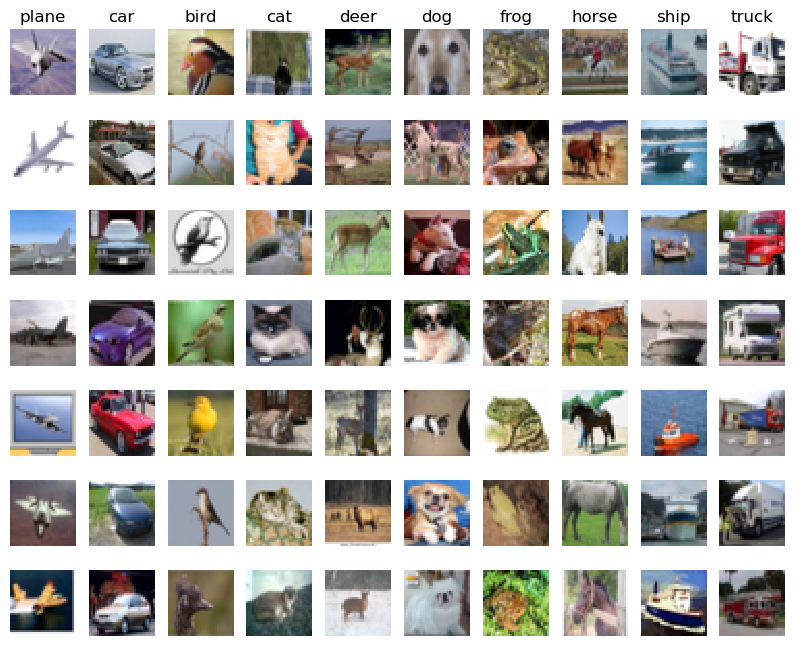

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
# newshape with -1 means inferred the remaining dimentions
# One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions.(https://numpy.org/devdocs/reference/generated/numpy.reshape.html#numpy.reshape)


# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


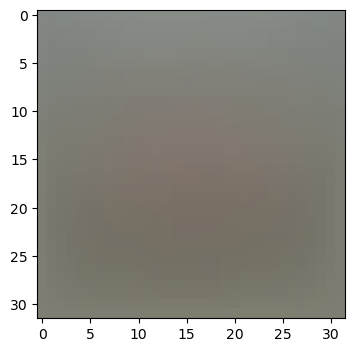

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
# extend the row with element 1
# from (49000,3072) to (49000,3073)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
# project to 10 class
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

100%|██████████| 500/500 [00:00<00:00, 14142.62it/s]

loss: 9.229859


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

100%|██████████| 500/500 [00:00<00:00, 10385.69it/s]


numerical: 13.089142 analytic: 13.089142, relative error: 2.627355e-11


100%|██████████| 500/500 [00:00<00:00, 12206.73it/s]


numerical: -10.046342 analytic: -10.046342, relative error: 2.213917e-12


100%|██████████| 500/500 [00:00<00:00, 14113.02it/s]


numerical: 9.859763 analytic: 9.859763, relative error: 2.378087e-11


100%|██████████| 500/500 [00:00<00:00, 13477.75it/s]


numerical: 17.514393 analytic: 17.514393, relative error: 2.134593e-11


100%|██████████| 500/500 [00:00<00:00, 14459.13it/s]


numerical: -4.570286 analytic: -4.570286, relative error: 1.514353e-10


100%|██████████| 500/500 [00:00<00:00, 12982.73it/s]


numerical: -24.833426 analytic: -24.833426, relative error: 4.413455e-14


100%|██████████| 500/500 [00:00<00:00, 13059.04it/s]


numerical: -23.770068 analytic: -23.770068, relative error: 3.239656e-12


100%|██████████| 500/500 [00:00<00:00, 14364.74it/s]


numerical: 5.100335 analytic: 5.100335, relative error: 1.271666e-11


100%|██████████| 500/500 [00:00<00:00, 14601.17it/s]


numerical: -3.839253 analytic: -3.839253, relative error: 1.178339e-10


100%|██████████| 500/500 [00:00<00:00, 12582.21it/s]


numerical: -6.832350 analytic: -6.832350, relative error: 2.413500e-11


100%|██████████| 500/500 [00:00<00:00, 14551.13it/s]


numerical: -13.231184 analytic: -13.231184, relative error: 3.885215e-12


100%|██████████| 500/500 [00:00<00:00, 13876.66it/s]


numerical: 34.010273 analytic: 34.010273, relative error: 2.166605e-12


100%|██████████| 500/500 [00:00<00:00, 14613.48it/s]


numerical: -31.064163 analytic: -31.064163, relative error: 6.710939e-12


100%|██████████| 500/500 [00:00<00:00, 13641.34it/s]


numerical: -17.124237 analytic: -17.124237, relative error: 2.572559e-11


100%|██████████| 500/500 [00:00<00:00, 14070.50it/s]


numerical: 43.077593 analytic: 43.077593, relative error: 2.364485e-12


100%|██████████| 500/500 [00:00<00:00, 12266.56it/s]


numerical: -4.419909 analytic: -4.419909, relative error: 4.752154e-12


100%|██████████| 500/500 [00:00<00:00, 15066.72it/s]


numerical: -1.471896 analytic: -1.471896, relative error: 2.659285e-10


100%|██████████| 500/500 [00:00<00:00, 11696.20it/s]


numerical: -5.482809 analytic: -5.482809, relative error: 8.582486e-12


100%|██████████| 500/500 [00:00<00:00, 12349.19it/s]


numerical: 18.580460 analytic: 18.587312, relative error: 1.843513e-04


100%|██████████| 500/500 [00:00<00:00, 13642.23it/s]

numerical: 17.512097 analytic: 17.512097, relative error: 3.433071e-11


**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*

the way to change is to use some function that have smooth shape


In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

100%|██████████| 500/500 [00:00<00:00, 13834.37it/s]

Naive loss: 9.229859e+00 computed in 0.038664s
Vectorized loss: 9.229859e+00 computed in 0.002473s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

100%|██████████| 500/500 [00:00<00:00, 11014.74it/s]

Naive loss and gradient: computed in 0.046678s
Vectorized loss and gradient: computed in 0.002082s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 417.995655
iteration 100 / 1500: loss 248.047734
iteration 200 / 1500: loss 150.865336
iteration 300 / 1500: loss 92.819293
iteration 400 / 1500: loss 57.635532
iteration 500 / 1500: loss 36.810016
iteration 600 / 1500: loss 23.863674
iteration 700 / 1500: loss 16.442337
iteration 800 / 1500: loss 12.109549
iteration 900 / 1500: loss 9.844995
iteration 1000 / 1500: loss 7.237088
iteration 1100 / 1500: loss 6.365209
iteration 1200 / 1500: loss 5.347293
iteration 1300 / 1500: loss 5.280220
iteration 1400 / 1500: loss 5.528958
That took 1.291737s


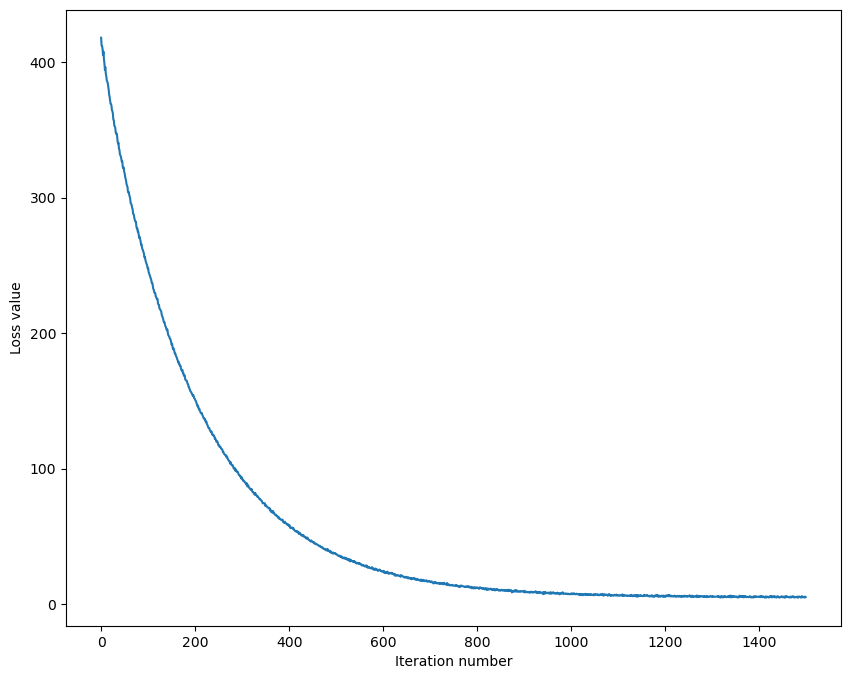

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.381653
validation accuracy: 0.385000


  0%|          | 0/5 [00:00<?, ?it/s]/home/lh/PycharmProjects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:106: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W * W)
/home/lh/miniconda3/envs/cs231n/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lh/PycharmProjects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:106: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W * W)
/home/lh/PycharmProjects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:155: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + reg * W
/home/lh/PycharmProjects/cs231n/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: invalid value encountered in matmul
  scores = np.matmul(X, W)
/home/lh/PycharmProjects/cs231n/assignment1/c

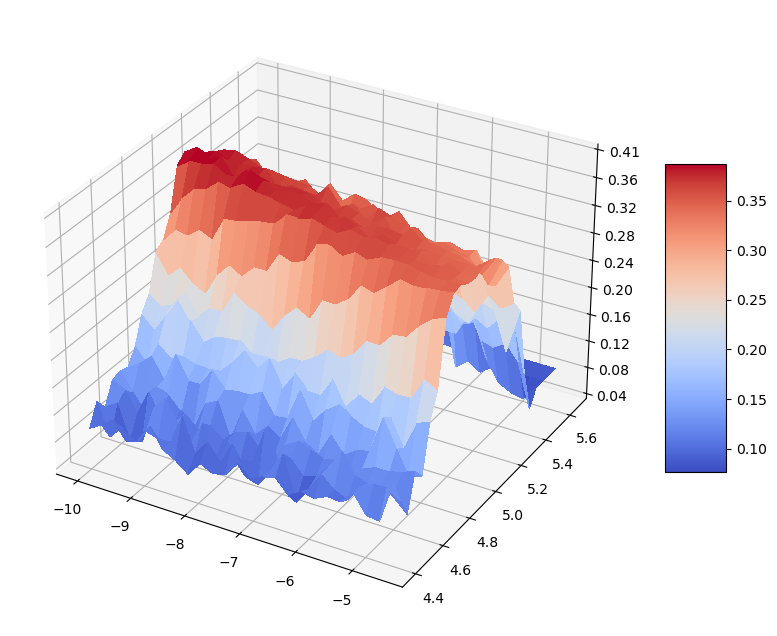

 20%|██        | 1/5 [13:28<53:54, 808.71s/it]

best{(9.19315118362663e-08, 28182.609852042744): [0.3833673469387755, 0.395]}
adjust gird from (1e-10,24999.999999999993) -> (2.9580887799322618e-05,443535.92749656877)
decrease area
[1.55390049e-07 3.21770927e-08 5.43883147e-08 2.62652780e-07
 1.55390049e-07 1.55390049e-07 9.19315118e-08 5.43883147e-08
 3.21770927e-08 2.62652780e-07 9.19315118e-08 5.43883147e-08
 9.19315118e-08 5.43883147e-08 5.43883147e-08 1.55390049e-07
 5.43883147e-08 9.19315118e-08 5.43883147e-08 9.19315118e-08]
[45514.10507565 40374.28161781 73503.97183628 31770.3799229
 51308.25064448 28182.60985204 45514.10507565 45514.10507565
 51308.25064448 35814.88888873 25000.         31770.3799229
 31770.3799229  57840.01640417 28182.60985204 31770.3799229
 35814.88888873 35814.88888873 51308.25064448 28182.60985204]
expand gird to (3.217709271659468e-08,24999.999999999993) -> (2.4149525088653604e-07,70400.53753734057)


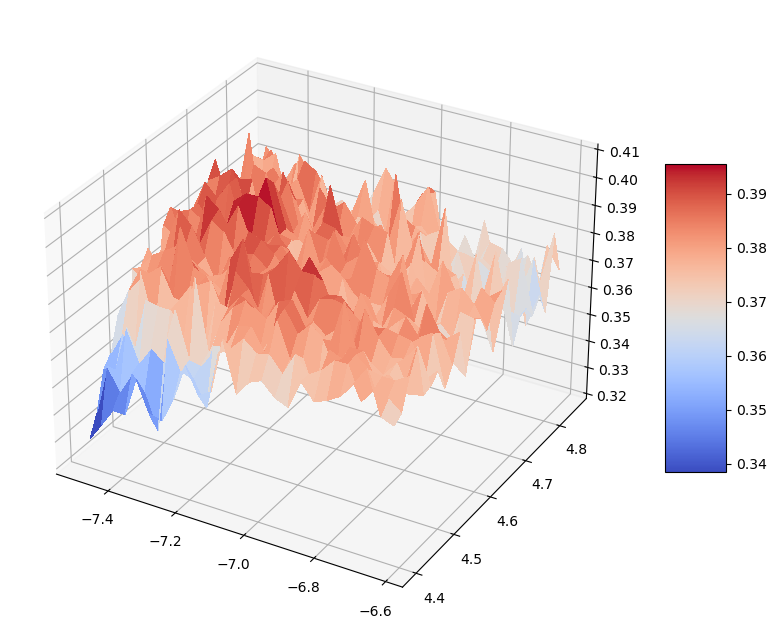

 40%|████      | 2/5 [26:06<38:56, 778.73s/it]

best{(1.0427363521563403e-07, 32385.380223777476): [0.3749387755102041, 0.403]}
adjust gird from (3.217709271659468e-08,24999.999999999993) -> (2.4149525088653604e-07,70400.53753734057)
decrease area
[8.81510923e-08 8.81510923e-08 4.50236225e-08 6.29990595e-08
 1.23344938e-07 6.85184412e-08 1.04273635e-07 1.13409105e-07
 9.58740572e-08 9.58740572e-08 1.45904319e-07 8.10502372e-08
 5.79242819e-08 1.13409105e-07 5.32582939e-08 1.72589735e-07
 1.72589735e-07 1.23344938e-07 5.32582939e-08 1.04273635e-07]
[31018.02690586 47748.80287615 54345.92480533 43801.88734303
 27252.70860032 27252.70860032 28454.07713482 28454.07713482
 31018.02690586 32385.38022378 54345.92480533 28454.07713482
 41952.51408955 32385.38022378 29708.40504216 43801.88734303
 26102.06342434 38484.7197253  36859.84427712 32385.38022378]
expand gird to (4.5023622457038185e-08,26102.06342433605) -> (1.6355807155413224e-07,52774.88526813726)


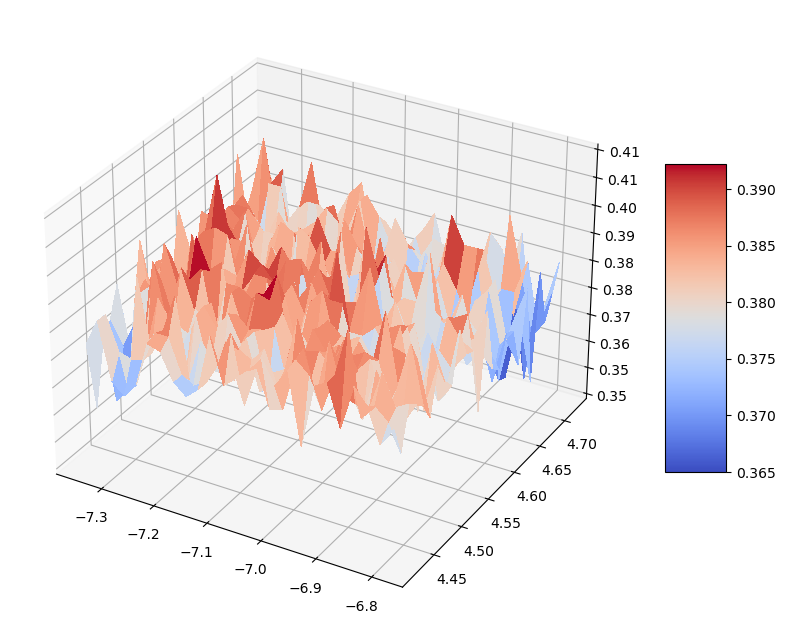

 60%|██████    | 3/5 [37:49<24:48, 744.00s/it]

best{(9.555252545360342e-08, 27679.24323092942): [0.38151020408163266, 0.403]}
adjust gird from (4.5023622457038185e-08,26102.06342433605) -> (1.6355807155413224e-07,52774.88526813726)
decrease area
[5.58228954e-08 6.55905544e-08 7.30343661e-08 5.01333119e-08
 6.55905544e-08 8.13229691e-08 6.21581844e-08 5.58228954e-08
 1.46887899e-07 1.46887899e-07 9.55525255e-08 9.55525255e-08
 1.31916785e-07 6.92124596e-08 1.25013546e-07 7.70673180e-08
 9.55525255e-08 1.46887899e-07 4.75098233e-08 9.55525255e-08]
[51249.26155994 27679.24323093 28503.21821931 28503.21821931
 36042.20757225 41735.90278234 46931.94520687 28503.21821931
 30225.48436615 48329.04803528 37115.13710713 45575.23002092
 26102.06342434 29351.72186896 44257.73494588 39357.76612127
 39357.76612127 26879.08782588 46931.94520687 27679.24323093]
expand gird to (4.750982329735673e-08,26102.06342433605) -> (1.4040349379463152e-07,49884.6697311541)


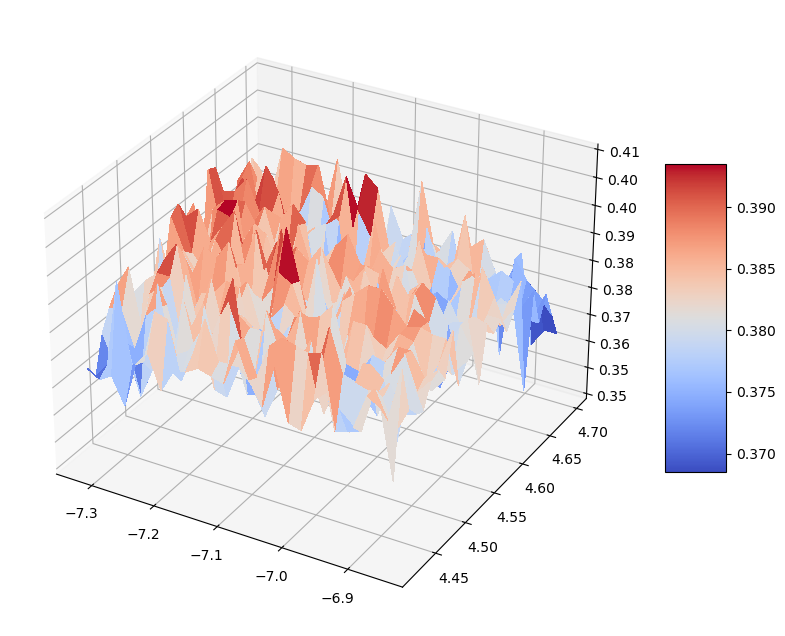

 80%|████████  | 4/5 [49:41<12:11, 731.68s/it]

best{(7.46215828140352e-08, 34188.49231730486): [0.3759183673469388, 0.402]}
adjust gird from (4.750982329735673e-08,26102.06342433605) -> (1.4040349379463152e-07,49884.6697311541)
decrease area
[9.78392425e-08 6.51688630e-08 8.16734056e-08 7.13273933e-08
 8.54454161e-08 1.34205344e-07 7.80679115e-08 1.17204827e-07
 7.80679115e-08 5.19995546e-08 1.12030789e-07 1.02357857e-07
 7.13273933e-08 9.78392425e-08 7.80679115e-08 1.28280814e-07
 1.17204827e-07 1.22617823e-07 5.44011058e-08 7.46215828e-08]
[31529.59677084 28303.2542831  26102.06342434 30690.07189168
 29077.48792504 27549.63582408 41297.4774999  26816.08363646
 31529.59677084 42427.16725528 28303.2542831  26102.06342434
 37071.61291741 26102.06342434 33278.17018125 38085.70442767
 33278.17018125 34188.4923173  34188.4923173  34188.4923173 ]
expand gird to (5.1999554569882165e-08,26102.06342433605) -> (1.3420534435178557e-07,41610.72361365613)


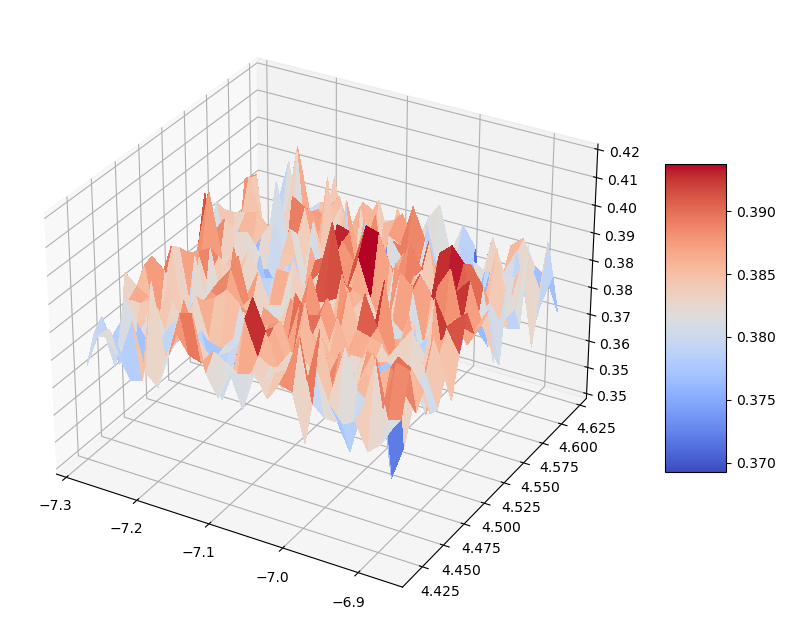

100%|██████████| 5/5 [1:01:37<00:00, 739.46s/it]

best{(8.5137348573402e-08, 26102.06342433605): [0.37979591836734694, 0.405]}
adjust gird from (5.1999554569882165e-08,26102.06342433605) -> (1.3420534435178557e-07,41610.72361365613)
decrease area
[1.11023720e-07 1.06891942e-07 9.53965224e-08 5.60972069e-08
 1.11023720e-07 9.53965224e-08 1.15315206e-07 5.82655762e-08
 8.84282292e-08 7.59814712e-08 8.84282292e-08 9.53965224e-08
 9.53965224e-08 5.40095341e-08 7.59814712e-08 9.53965224e-08
 1.24402239e-07 8.51373486e-08 1.06891942e-07 8.51373486e-08]
[28211.74254403 40809.99113691 32956.4219371  38499.06630904
 37758.21274917 31700.23770536 31700.23770536 34934.64689146
 34934.64689146 29905.16585355 31700.23770536 28765.28489607
 28211.74254403 29329.68829772 27668.85223791 32322.22779024
 26614.21178094 34934.64689146 27136.40899595 26102.06342434]
expand gird to (5.400953409954511e-08,26102.06342433605) -> (1.2031890897073567e-07,40086.93335572106)


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-10, 5e-5]
regularization_strengths = [2.5e4, 5e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# apply gird searching:
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from cs231n.classifiers.linear_svm import visualize_lr_reg_valloss,division_10exponential_to_k,generation_space
# set split k_fold of each range
k_fold = 25
# set iteration times
max_iter = 5
# set top_k value as the last searching space
top_k = 20
lr_range = division_10exponential_to_k(learning_rates[0],learning_rates[1],k_fold)
reg_range = division_10exponential_to_k(regularization_strengths[0],regularization_strengths[1],k_fold)
search_space = [(x,y) for x in lr_range for y in reg_range]
for i in tqdm(range(max_iter)):
    results_acc = []
    for para in search_space:
        # search in space
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=para[0], reg=para[1],
                      num_iters=1500, verbose=False)
        results_acc.append([np.mean(y_train==svm.predict(X_train)),np.mean(y_val==svm.predict(X_val))])
    visualize_lr_reg_valloss(lr_range,reg_range,results_acc,i)
    lr_range,reg_range,search_space,dict_result = generation_space(lr_range, reg_range, results_acc,k_fold,top_k)
    results.update(dict_result)

    #todo: visualize the results
    #   -with exponents
    #   - 3-D pic
    #todo: select top-k ,and continue loop

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



In [51]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

    best_val = val_accuracy if val_accuracy > best_val else best_val

print('best validation accuracy achieved during cross-validation: %f' % best_val)
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    if val_accuracy == best_val:
        best_svm = LinearSVM()
        best_svm.train(X_train, y_train, learning_rate=para[0], reg=para[1],
                      num_iters=1500, verbose=False)
        break


lr 7.462158e-08 reg 3.418849e+04 train accuracy: 0.375918 val accuracy: 0.402000
lr 8.513735e-08 reg 2.610206e+04 train accuracy: 0.379796 val accuracy: 0.405000
lr 9.193151e-08 reg 2.818261e+04 train accuracy: 0.383367 val accuracy: 0.395000
lr 9.555253e-08 reg 2.767924e+04 train accuracy: 0.381510 val accuracy: 0.403000
lr 1.042736e-07 reg 3.238538e+04 train accuracy: 0.374939 val accuracy: 0.403000
best validation accuracy achieved during cross-validation: 0.405000


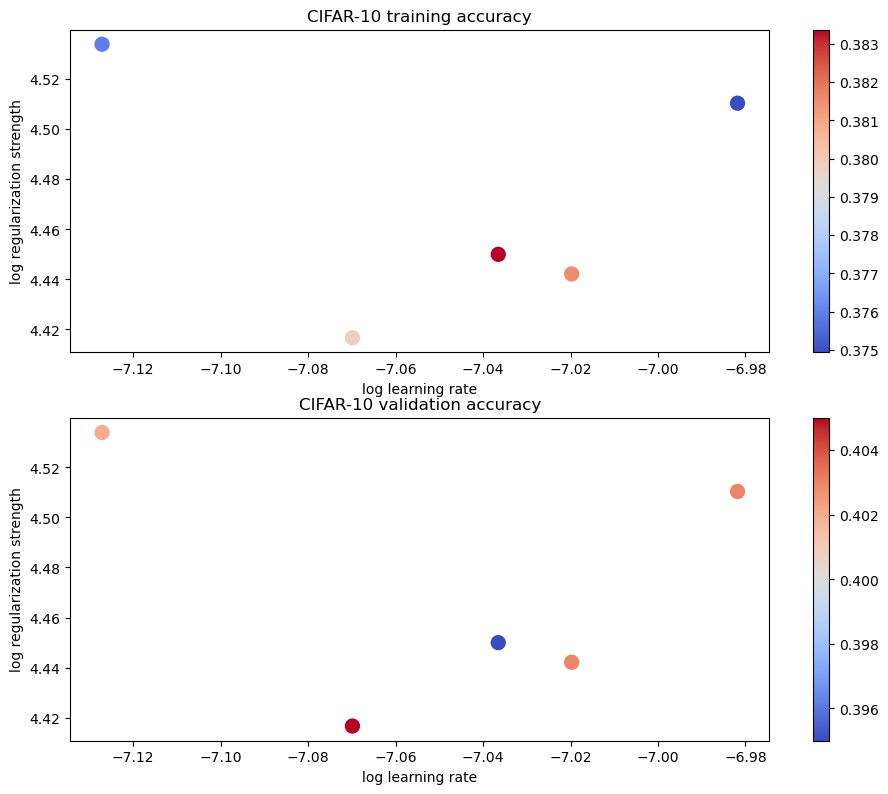

In [52]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [53]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.362000


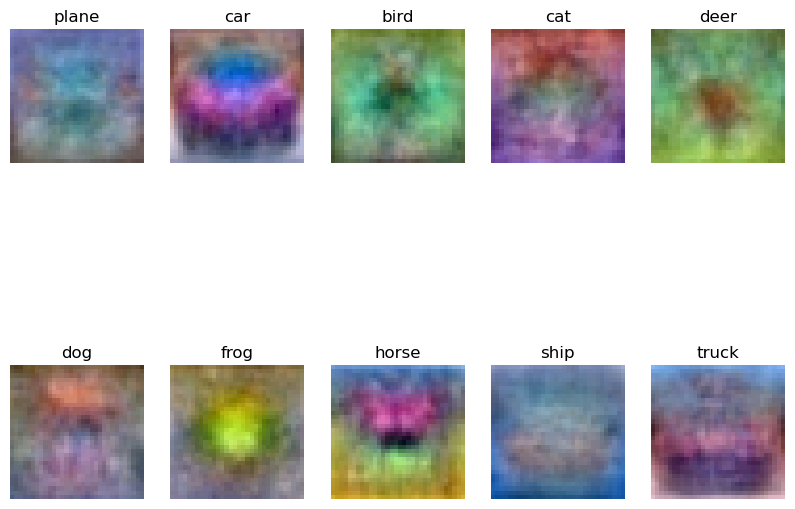

In [54]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
